# Image Segmentation of Brain MRI image of Low Grade Glioma

---

Downloading files from Kaggle

In [0]:
#Below to be done to download data from Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip
!mv "kaggle_3m/data.csv" .
!mv "kaggle_3m/README.md" .
!rm lgg-mri-segmentation.zip

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout,Conv2DTranspose, MaxPooling2D, concatenate, Input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  
from scipy.ndimage import zoom, rotate

import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
from pathlib import os
import fnmatch

Define constants

In [0]:
IMAGE_PATH="kaggle_3m"
INITIAL_DEPTH = 64
INPUT_SIZE = 128
INPUT_DEPTH = 1
NUM_CONTRACTION = 5
NUM_EXPANSION = NUM_CONTRACTION - 1
FILTER_SIZE = 3
POOL_SIZE = 2
DROP_OUT = 0.2
BATCH_SIZE=16

---
## Analysis of images

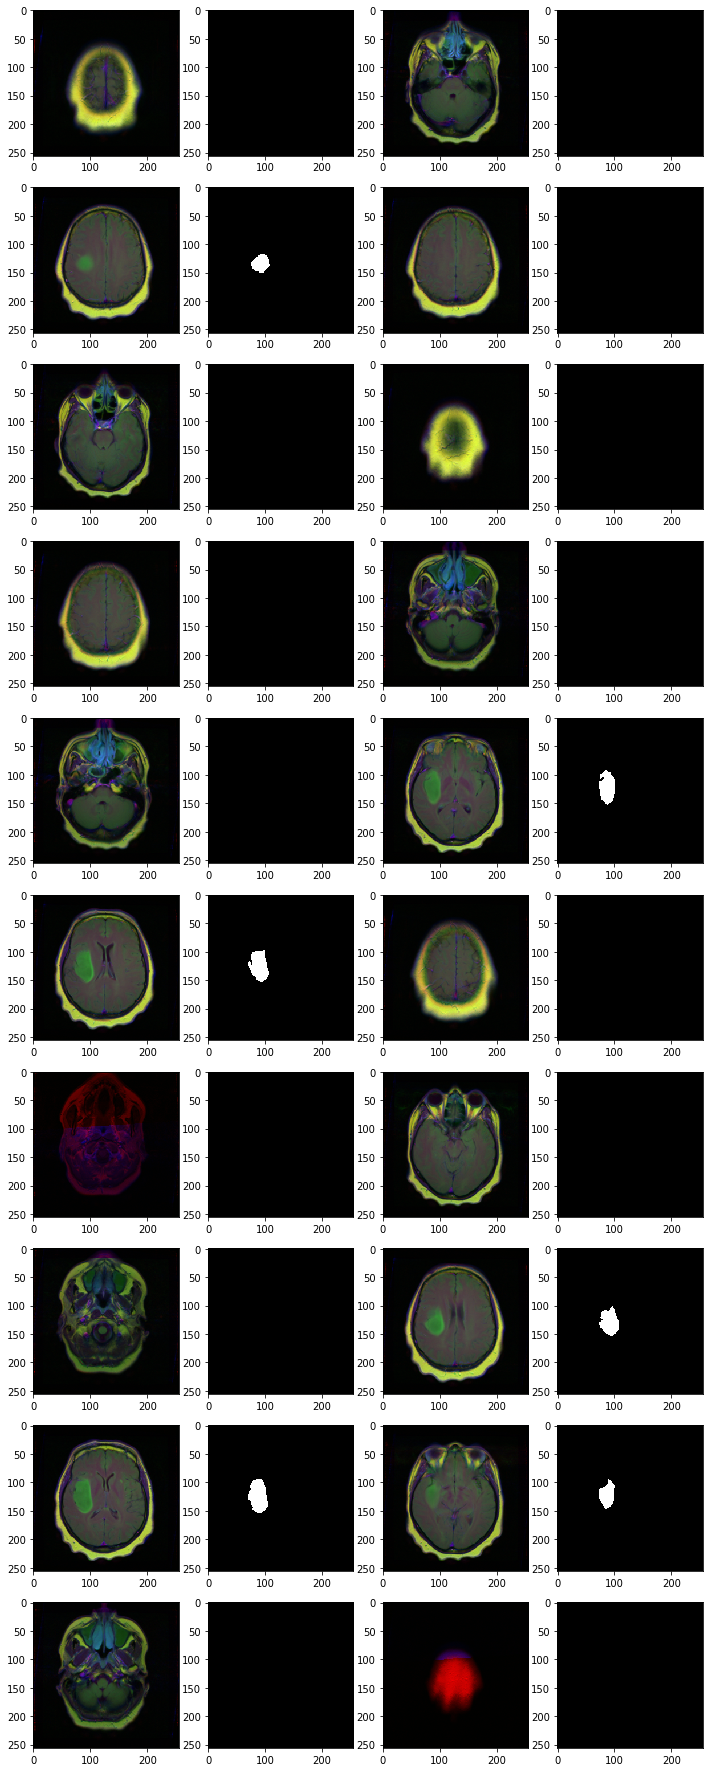

In [0]:
fig=plt.figure(figsize=(12, 32))
i=1
for path in os.listdir(IMAGE_PATH):
  dirlist = os.listdir(IMAGE_PATH+"/"+ path)
  row = len(dirlist) /4 
 
  for f in dirlist:
    if fnmatch.fnmatch(f,"*mask*.tif"):
      continue
    mask_f = f.split(".")
    mask_f = "".join([mask_f[0],"_mask.",mask_f[1]])
    fig.add_subplot(row, 4, i)
    i=i+1
    plt.imshow(image.load_img(str(IMAGE_PATH+"/"+ path+"/"+f)))
    fig.add_subplot(row, 4, i)
    i=i+1
    plt.imshow(image.load_img(str(IMAGE_PATH+"/"+ path+"/"+mask_f)))
  break
  plt.show()

Above the images and their masks are loaded.

Below a function is created to generate images as X and masks as y. 
1. Source images are read in grayscale for better prediction.
2. Images and masks are scaled and balanced for better prediction

In [0]:
def get_images(img_path):
  X=[]
  y=[]
  for path in os.listdir(img_path):
    dirlist = os.listdir(img_path+"/"+ path)
    for f in dirlist:
      if fnmatch.fnmatch(f,"*mask*.tif"):
        continue
      mask_f = f.split(".")
      mask_f = "".join([mask_f[0],"_mask.",mask_f[1]])
      x_arr = image.img_to_array(
          image.load_img(str(img_path+"/"+ path+"/"+f),
                             target_size=(128,128),
                        color_mode="grayscale")
      )
      y_arr =image.img_to_array(
          image.load_img(str(img_path+"/"+ path+"/"+mask_f),
                              target_size=(128,128),
                         color_mode="grayscale")
      )
      X.append(x_arr /255.)
      y.append(y_arr /255.)

  X = np.asarray(X)
  y = np.asarray(y)
  
  return X, y

In [0]:
#X_train = np.append(X_train, X_train, axis=0)
#y_train = np.append(y_train, y_train, axis=0)

#data_gen_args = dict(rotation_range=40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest')

#X_train_datagen = ImageDataGenerator(**data_gen_args)
#y_train_datagen = ImageDataGenerator(**data_gen_args)


##X_test_datagen = ImageDataGenerator()

#seed = 27
#X_train_datagen.fit(X_train, augment=True, seed=seed)
#y_train_datagen.fit(y_train, augment=True, seed=seed)

#X_train_images = X_train_datagen.flow(X_train,
#                                      seed=seed,
#                                     batch_size=BATCH_SIZE)

#y_train_images = y_train_datagen.flow(y_train,
#                                      seed=seed,
#                                     batch_size=BATCH_SIZE)

##train_generator = zip(X_train_images, y_train_images)

#def combine_generator(gen1, gen2):
#    while True:
#        yield(gen1.next(), gen2.next()) 

Functions are created to augment the images for better prediction

In [0]:
#code taken from stackoverflow
def clipped_zoom(img, zoom_factor):

    h, w = img.shape[:2]

    # For multichannel images 
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)
        
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def augment_append_images(X_train, y_train):
  total=X_train.shape[0]
  rand_lr = np.random.randint(0,high=total,size=int(0.5*total))
  rand_ud = np.random.randint(0,high=total,size=int(0.5*total))
  #rand_zoom_in = np.random.randint(0,high=total,size=int(0*total))
  #rand_zoom_out = np.random.randint(0,high=total,size=int(0*total))
  #rand_rotate = np.random.randint(0,high=total,size=int(0*total))

  X_train = np.concatenate((
      X_train,
      np.array([np.fliplr(X_train[i]) for i in rand_lr]),
      np.array([np.flipud(X_train[i]) for i in rand_ud]),
      #np.array([clipped_zoom(X_train[i],0.3) for i in rand_zoom_in]),
      #np.array([clipped_zoom(X_train[i],2) for i in rand_zoom_out]),
      #np.array([rotate(X_train[i],40,reshape=False) for i in rand_rotate])
      ),
      axis=0
  )
  
  y_train = np.concatenate((
      y_train, 
      np.array([np.fliplr(y_train[i]) for i in rand_lr]),
      np.array([np.flipud(y_train[i]) for i in rand_ud]),
      #np.array([clipped_zoom(y_train[i],0.3) for i in rand_zoom_in]),
      #np.array([clipped_zoom(y_train[i],2) for i in rand_zoom_out]),
      #np.array([rotate(y_train[i],40,reshape=False) for i in rand_rotate])
      ),
      axis=0
  )
  return X_train, y_train

Images and masks are split as Training and Testing sets

In [0]:
X, y = get_images(IMAGE_PATH)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27)

X_train, y_train = augment_append_images(X_train, y_train)

print(X_train.shape)

(6285, 128, 128, 1)



---
## UNet


Function to plot accuracy and loss between Training and Validation

In [0]:
# PLOT LOSS AND ACCURACY
def plot_acc_loss(history, relative=True):
  acc=history.history['acc']
  val_acc=history.history['val_acc']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) 

  plt.plot(epochs, acc, 'r')
  plt.plot(epochs, val_acc, 'b')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])
  plt.title('Training and validation accuracy')
  if relative==False:
    plt.yticks(np.arange(0, 1, step=0.05))
  plt.figure()

  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])
  plt.title('Training and validation loss')
  if relative==False:
    y_max = max(loss) if max(loss)>max(val_loss) else max(val_loss)
    y_max = 1 if y_max < 1 else y_max
    plt.yticks(np.arange(0, y_max, step=0.05))
  plt.figure()

---
**Custom Unet**


In [0]:
def get_unet(filter_size=FILTER_SIZE, 
             input_size=(INPUT_SIZE,INPUT_SIZE,INPUT_DEPTH),
            intial_depth=INITIAL_DEPTH,
            num_slab=NUM_CONTRACTION,
            pool_size=POOL_SIZE,
            drop_out=DROP_OUT):
  
  #layers_skip will keep track of skip layers to be added in upward feed
  layers_skip=[]
  
  depth=intial_depth
  input_layer = Input(input_size)
  x = None
  
  ####Downward feed
  for i in range(num_slab):
    
    #### Two Conv2D layers #####
    
    #For first slab, input comes from input layer
    if i==0:
      layers = Conv2D(depth,(filter_size,filter_size),kernel_initializer='he_normal',
                      activation='relu',padding="same", )(input_layer)
    else:
      layers = Conv2D(depth,(filter_size,filter_size),kernel_initializer='he_normal',
                  activation='relu',padding="same")(layers)

    layers = Conv2D(depth,(filter_size,filter_size),kernel_initializer='he_normal',
               activation='relu',padding="same")(layers)

    #### Max Pooling and Dropout #####
    #Pooling, Dropout, skip, depth increase are not applicable for last slab
    if i!=num_slab-1:
      
      #The layer right before Max Pooling is the counter part for enhancement
      #using skip in the upward feed
      layers_skip.append(layers)
      layers = MaxPooling2D(pool_size,pool_size)(layers)
      layers = Dropout(drop_out)(layers)
      
      #Depth is multiplied for each slab in downward feed
      depth = depth*2


  uplen = len(layers_skip)
  
  #### UPWARD FEED ####
  for i in range(NUM_EXPANSION):
    
    # Adding the SKIP layer from Downward feed to Conv2D Transpose
    # Conv2DTranspose is used instead of 
    # Upsampling so that weights can be calculated by the model
    layers = concatenate([Conv2DTranspose(
        depth,(filter_size,filter_size),strides=(2, 2),
        padding="same")(layers),layers_skip[uplen-1]])

    layers = Dropout(drop_out)(layers)
    
    ## Two layers of Conv2D to increase dimension to be equivalent to input
    layers = Conv2D(depth,(filter_size,filter_size),kernel_initializer='he_normal',
               activation='relu',padding="same")(layers)
    layers = Conv2D(depth,(filter_size,filter_size),kernel_initializer='he_normal',
               activation='relu',padding="same")(layers)
    
    uplen = uplen-1
    depth=int(depth/2)

  # Sigmoid activation to predict output of each pixel
  layers = Conv2D(1,(1,1),activation='sigmoid',padding="same")(layers)

  #Model with input_layer and ouput as last layer of Unet structure
  model = Model(inputs=[input_layer], outputs=[layers])
  return model

In [0]:
model = get_unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

**Metrics and Loss**

In [0]:
#Functions available in github and other social websites 
#were calculating sum(intersections of all images)/sum(union of all images).
#my method calculates sum(intersection of an image/union of an image).

from tensorflow.keras.losses import binary_crossentropy
def mean_iou(y_true, y_pred):
    #prec = []
    #for t in np.arange(0.5, 1.0, 0.05):
        y_pred_i = tf.to_int32(y_pred > 0.5)
        y_true_i = tf.to_int32(y_true)
        intersection = tf.reduce_sum(
            tf.reduce_sum(y_pred_i*y_true_i,axis=1),axis=1
        )
        union = tf.reduce_sum(
            tf.reduce_sum(y_pred_i+y_true_i,axis=1),axis=1
        ) - intersection
        
        num_valid_entries = tf.reduce_sum(
            tf.cast(
                tf.not_equal(union, 0), dtype=tf.dtypes.float64
            )
        )
        union = tf.where(tf.greater(union, 0), union,
                                tf.ones_like(union))
        iou = tf.math.divide(intersection, union)
        mean_iou = tf.where(
            tf.greater(num_valid_entries, 0),
            tf.reduce_sum(iou, name='mean_iou') / num_valid_entries, 0
        )
        return mean_iou
        #score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        #K.get_session().run(tf.local_variables_initializer())
        #with tf.control_dependencies([up_opt]):
        #    score = tf.identity(score)
        #prec.append(score)
        #return score
    #return K.mean(K.stack(prec))

smooth = 1.
#Functions in the social sites flattened the y_true and y_pred. This means
# they were calculating 2*sum(intersection)/sum(A)+sum(B).
#I changed the method to reflect sum of(2*intersection/(A+B))
def dice_coef(y_true, y_pred):
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.sum(y_true * y_pred,axis=1),axis=1)
    union = K.sum(
            K.sum(y_pred+y_true,axis=1),axis=1
        )
    dice_coef = (2. * intersection + smooth) / (union + smooth)
    return K.mean(dice_coef)
  
def custom_loss(y_true, y_pred):
  return binary_crossentropy(y_true,y_pred)-K.log(dice_coef(y_true, y_pred))

In [0]:
#model.compile(optimizer=Adam(lr=0.0001), loss=custom_loss, metrics=["accuracy",mean_iou])
model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy",mean_iou])

**Callback to adjust learning rate**

In [0]:
callbacks = [EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)]

In [0]:
history = model.fit(X_train, 
                      y_train,
                     #combine_generator(X_train_images,y_train_images),
                     #steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
                      epochs=100,
                      verbose=1,
                      batch_size=16,
                      shuffle=True,
                     validation_data=(X_test,y_test),
                   callbacks=callbacks
                   )
model.save("model_brain_segment.h5")

The training is done using custom loss as well as binary_cross entropy to document the accuracy and performance

**Results from loss: binary_crossentropy**

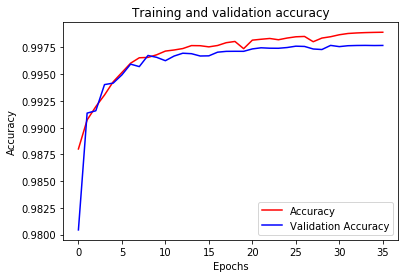

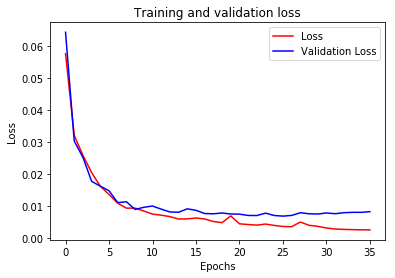

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history,True)

**Results from loss: custom_loss**

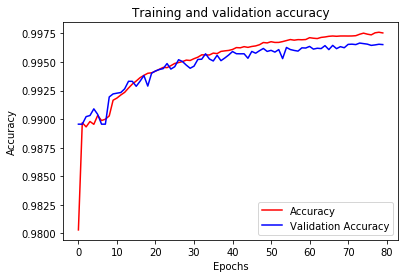

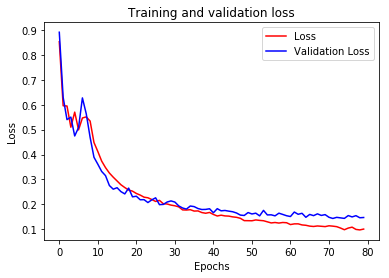

<Figure size 432x288 with 0 Axes>

In [0]:
plot_acc_loss(history,True)

It can be noted that custom_loss based training took nearly 80 epochs to converge to the same extent as binary_cross entropy based training which in turn took only about 35 epochs. Also there is a lot of fluctuations in loss in custom_loss model when compared to the other one.

---
## Predict Test results

Compute 3 different metrics 
1. IOU considering only positive values
2. DICE-COEFFICIENT
3. IOU considering both 0 and 1 as separate labels

In [0]:
def compute_metrics(y_pred, y_true):
  
  #intersection = np.sum(np.sum(y_pred*y_true,axis=1),axis=1)
  #union = np.sum(np.sum(y_pred+y_true,axis=1),axis=1) - intersection
  
  #iou = np.divide(intersection,union,
  #                     out=np.zeros_like(intersection), where=union!=0)
  
  #return np.mean(iou)
  y_pred_r = y_pred.reshape(y_pred.shape[0],y_pred.shape[1]**2)
  y_true_r = y_true.reshape(y_true.shape[0],y_true.shape[1]**2)
  iou = 0
  dice_coeff = 0
  iou_pos_neg = 0
  count = 0
  for i in range(y_pred_r.shape[0]):
    current = confusion_matrix(y_true_r[i], y_pred_r[i], labels=[0, 1])
    
    tp = current[1][1]
    fp = current[0][1]
    fn = current[1][0]
    tn = current[0][0]
    
    #iou_pos_neg
    mean_pos = 0
    mean_neg = 0
    if tn+fp+fn != 0:
      mean_neg = tn/(tn+fp+fn)
    if tp+fn+fp != 0:
      mean_pos = tp/(tp+fp+fn)
    iou_pos_neg += (mean_pos+mean_neg)/2
    
    #iou_pos
    if tp+fn == 0 and tp+fp == 0:
      continue
    iou_denominator = tp + fp+fn
    
    if iou_denominator !=0 :
      iou += tp / float(iou_denominator)
    
    #dice
    dice_denominator = (2*tp + fp+fn)
    #print(dice_denominator)
    #print(tp)
    if dice_denominator !=0 :
      dice_coeff += 2*tp / dice_denominator
      
    count += 1
  
  return iou/count, dice_coeff/count, iou_pos_neg/y_true.shape[0]
  

In [0]:
#def compute_iou_01(y_pred, y_true):
  # ytrue, ypred is a flatten vector
#  y_pred_r = y_pred.reshape(y_pred.shape[0],y_pred.shape[1]**2)
#  y_true_r = y_true.reshape(y_true.shape[0],y_true.shape[1]**2)
#  IoU = 0
#  for i in range(y_pred_r.shape[0]):
#    current = confusion_matrix(y_true_r[i], y_pred_r[i], labels=[0, 1])
    ## compute mean iou
#    intersection = np.diag(current)
#    ground_truth_set = current.sum(axis=1)
#    predicted_set = current.sum(axis=0)
#    union = ground_truth_set + predicted_set - intersection
#    IoU += np.nanmean(intersection / union.astype(np.float32))
#  return IoU/y_true.shape[0]

In [0]:
#def compute_dice_coef(y_pred, y_true):
  
  ##intersection = 2*np.sum(np.sum(y_pred*y_true,axis=1),axis=1)
  
  ##denominator = np.sum(np.sum(y_pred+y_true,axis=1),axis=1)
  ##diceloss = np.divide(intersection,denominator,
  ##                     out=np.zeros_like(intersection), where=denominator!=0)
  
'''
  y_pred_r = y_pred.reshape(y_pred.shape[0],y_pred.shape[1]**2)
  y_true_r = y_true.reshape(y_true.shape[0],y_true.shape[1]**2)
  dice_coeff = 0
  count = 0
  for i in range(y_pred_r.shape[0]):
    current = confusion_matrix(y_true_r[i], y_pred_r[i], labels=[0, 1])
    # compute mean iou
    tp = current[1][1]
    fp = current[0][1]
    fn = current[1][0]
    
    if tp+fn == 0 and tp+fp == 0:
      continue
    denominator = (2*tp + fp+fn)
    
    if denominator !=0 :
      dice_coeff += 2*tp / denominator
    count += 1
  return dice_coeff/count
  '''

In [0]:
predict_val = model.predict(X_test)

In [0]:
predict_val_baw = (predict_val>0.5).astype(np.uint8)


**Metrics from binary_crossentropy**

In [0]:
iou, dice, iou_pos_neg = compute_metrics(predict_val_baw,y_test)
print("iou: ", iou)
print("dice: ", dice)
print("iou considering both 0 and 1: ", iou_pos_neg)

iou:  0.6758829591977912
dice:  0.754927912496641
iou considering both 0 and 1:  0.6243537702281614


**Metrics from custom_loss**

In [0]:
iou, dice, iou_pos_neg = compute_metrics(predict_val_baw,y_test)
print("iou: ", iou)
print("dice: ", dice)
print("iou considering both 0 and 1: ", iou_pos_neg)

iou:  0.5958208716131282
dice:  0.6796563197081231
iou considering both 0 and 1:  0.603582377316564


From the metrics it can be concluded that prediction accuracy of binary_cross entropy is better than the one from custom_loss

---
## Plot random images, their labels and prediction results**

Random images are picked from test set and the model is used to predict. The mask in test set is compared against result. Following images are displayed for comparison
1. Actual brain mri
2. Actual mask
3. Predicted mask
4. Predicted mask that has be converted to 0s and 1s

**Images from binary_cross entropy**

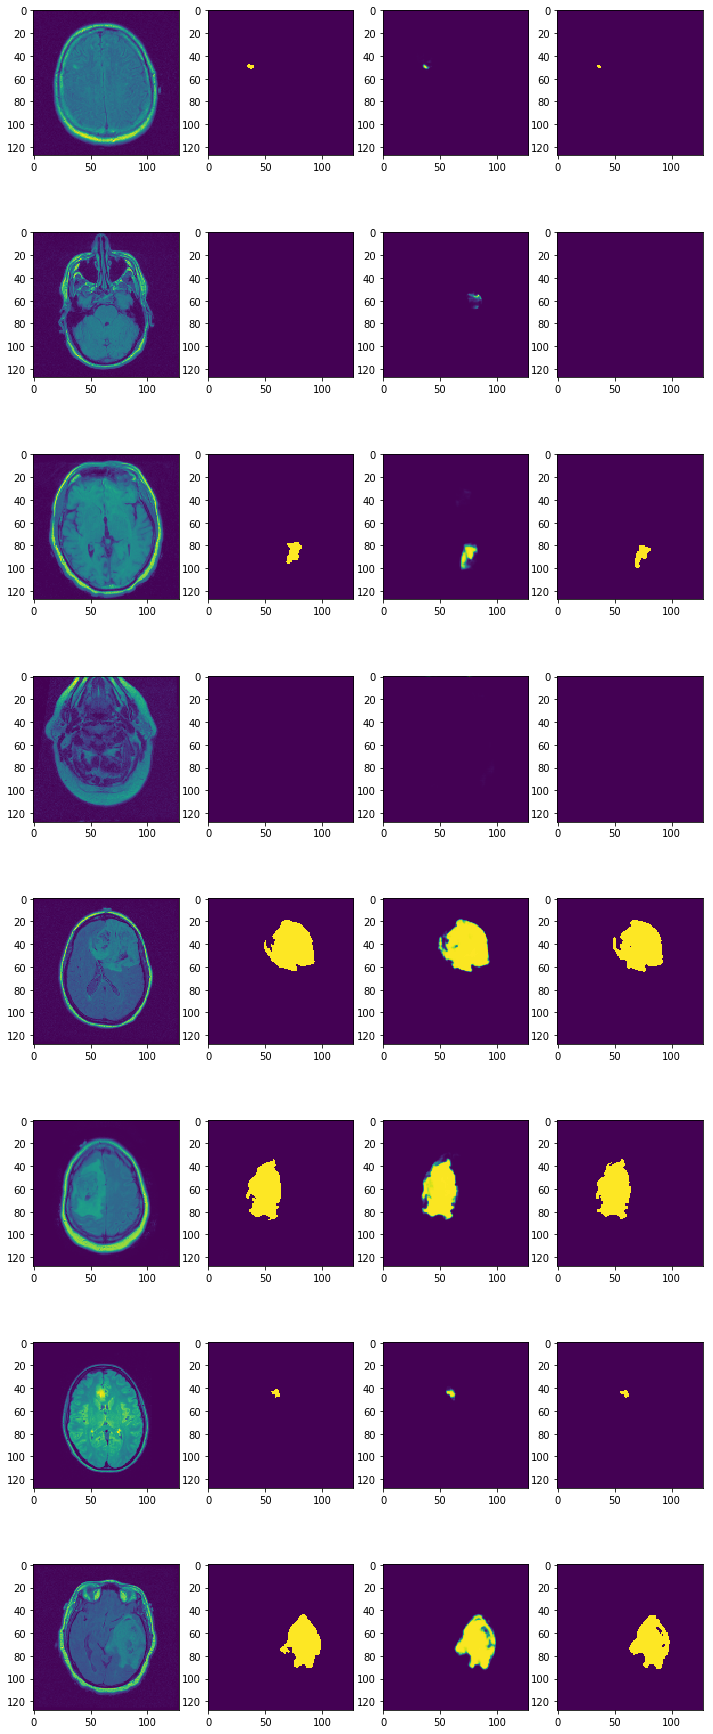

In [0]:
fig=plt.figure(figsize=(12, 32))
rand = np.random.randint(0,X_test.shape[0],8)
row = 8
col = 4
j = 0
for i in rand:
    fig.add_subplot(row, col, j*col+1)
    plt.imshow(image.array_to_img(X_test[i]))
    fig.add_subplot(row, col, j*col+2)
    plt.imshow(image.array_to_img(y_test[i]))
    fig.add_subplot(row, col, j*col+3)
    plt.imshow(image.array_to_img(predict_val[i]))
    fig.add_subplot(row, col, j*col+4)
    plt.imshow(image.array_to_img(predict_val_baw[i]))
    j += 1
plt.show()

**Prediction images from custom_loss**

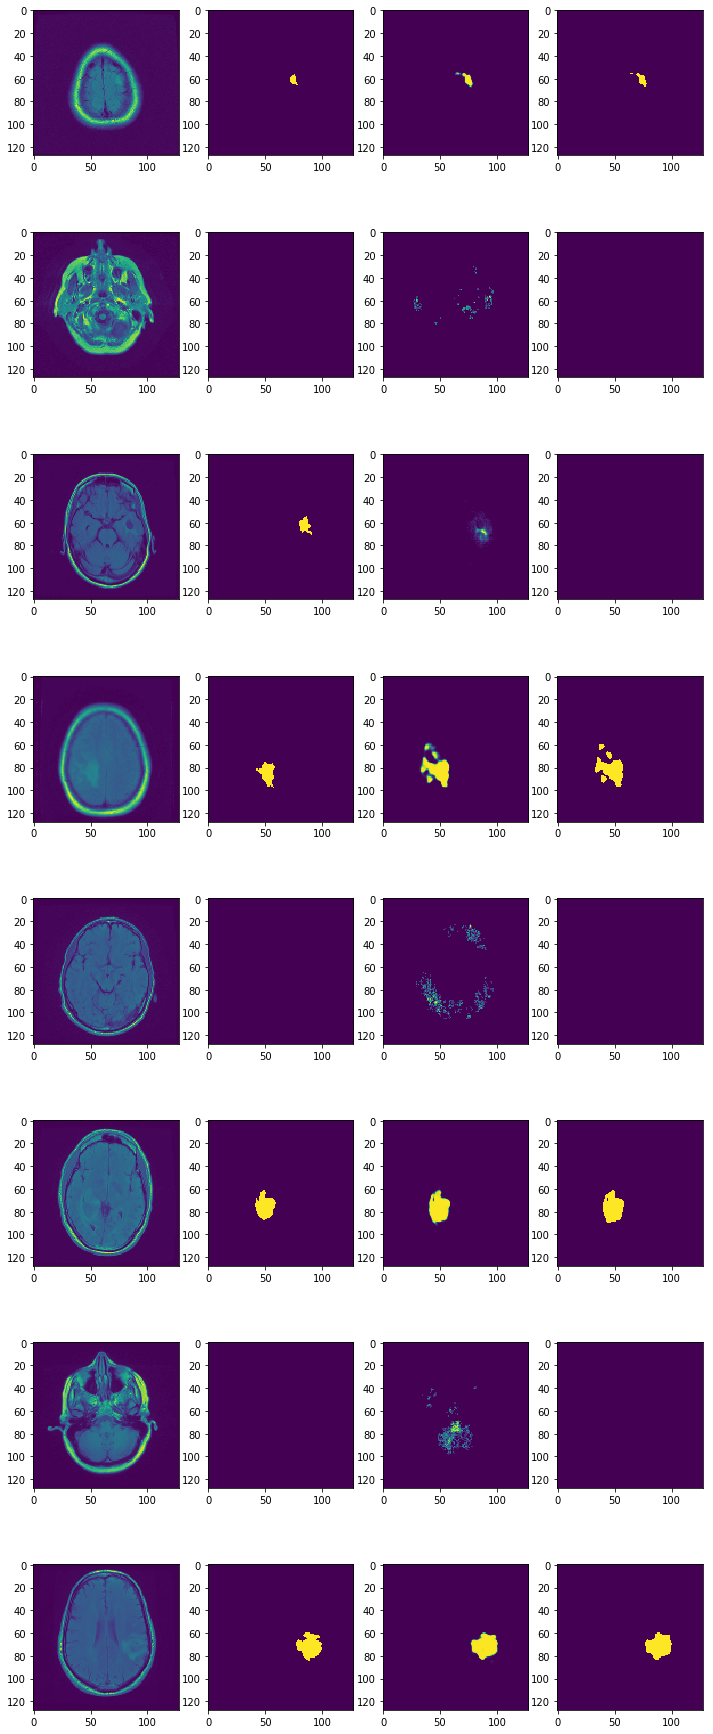

In [0]:
fig=plt.figure(figsize=(12, 32))
rand = np.random.randint(0,X_test.shape[0],8)
row = 8
col = 4
j = 0
for i in rand:
    fig.add_subplot(row, col, j*col+1)
    plt.imshow(image.array_to_img(X_test[i]))
    fig.add_subplot(row, col, j*col+2)
    plt.imshow(image.array_to_img(y_test[i]))
    fig.add_subplot(row, col, j*col+3)
    plt.imshow(image.array_to_img(predict_val[i]))
    fig.add_subplot(row, col, j*col+4)
    plt.imshow(image.array_to_img(predict_val_baw[i]))
    j += 1
plt.show()

From the images, it can be observed that model using binary_cross entropy is consistent and did not have false negatives. In case of the model that was trained using custom_loss, even though the masks are fairly accurate, it sometimes missed to predict a tumor (false negative).

In case of Brain tumor prediction a false negative is very costly. Considering all the analysis, it can be concluded that for a Brain MRI image, segmentation can be done very efficiently using a UNet model as well as binary_cross_entropy loss. IOU, Dice co-efficient can be used as metrics to compare the efficiency of the model. In order to get better results, UNet model could be enhanced to accept higher dimension of images and filters. 